__семантический сегментатор изображений__

Евгений Борисов esborisov@sevsu.ru

Mask R-CNN   
Kaiming He Georgia Gkioxari Piotr Dollar Ross Girshick   
Facebook AI Research (FAIR)   
24 Jan 2018

https://arxiv.org/pdf/1703.06870.pdf

---

In [1]:
import os
import numpy as np
from numpy import random as rng
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

---

In [3]:
# подгружаем предобученую модель mask-r-cnn
from torchvision.models.detection import maskrcnn_resnet50_fpn


model = maskrcnn_resnet50_fpn(pretrained=True) 
model = model.train(mode=False)

# (pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, 
# trainable_backbone_layers=None, **kwargs)

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

---

In [49]:
img_folder = '../data/pascal/'
files = os.listdir(img_folder)

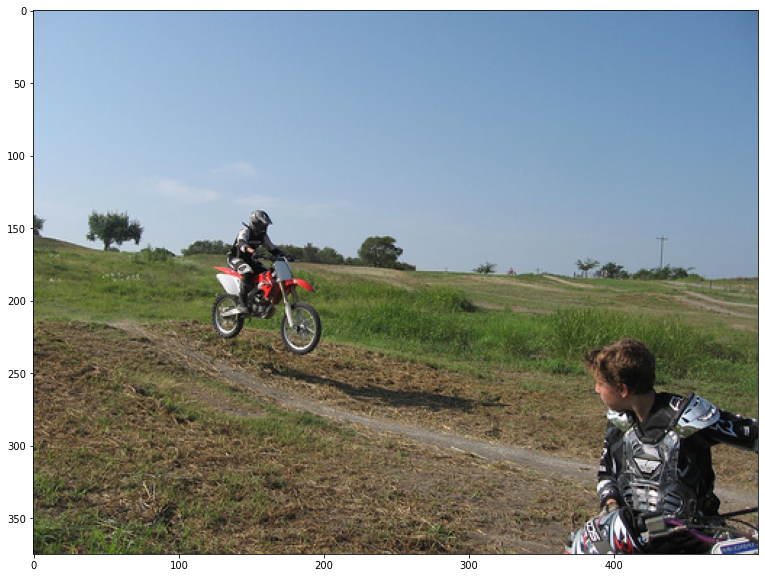

In [76]:
# выбираем случайное фото
f = rng.choice(files)
img = Image.open(os.path.join(img_folder,f))
# img
plt.figure(figsize=(15,10))
plt.imshow(img)

In [77]:
x = transforms.ToTensor()(img).unsqueeze(dim=0) # преобразуем фото в torch.tensor
with torch.no_grad():  # отключаем расчёт градиента
    o = model(x)  # считаем выход модели

In [78]:
# извлекаем результаты
boxes = o[0]['boxes'].detach().numpy() # рамки объектов
scores = o[0]['scores'].detach().numpy() # скор класса-результата
labels = o[0]['labels'].detach().numpy() # метка класса

# формируем имя объекта со скором
text = [ 
    '%s %.2f'%( COCO_INSTANCE_CATEGORY_NAMES[labels[n]],scores[n] )
    for n in range(len(labels))
    ]

masks = o[0]['masks'].detach().numpy() # маски сегментации объектов

In [79]:
# основной список цветов для рисования рамок объектов
colors = rng.permutation(['blue', 'green', 'orange', 'red', 'lightseagreen',]).tolist()

classes_idx = sorted( set(labels) ) # список меток обнаруженных классов 
# если классов больше чем базовых цветов то дополняем список цветов
s = len(classes_idx)-len(colors)
colors += [] if(s<1) else ['coral']*s

# назначаем цвета классов
colors = { classes_idx[n]:colors[n] for n in range(len(classes_idx)) }

motorcycle 1.00
person 1.00
person 1.00


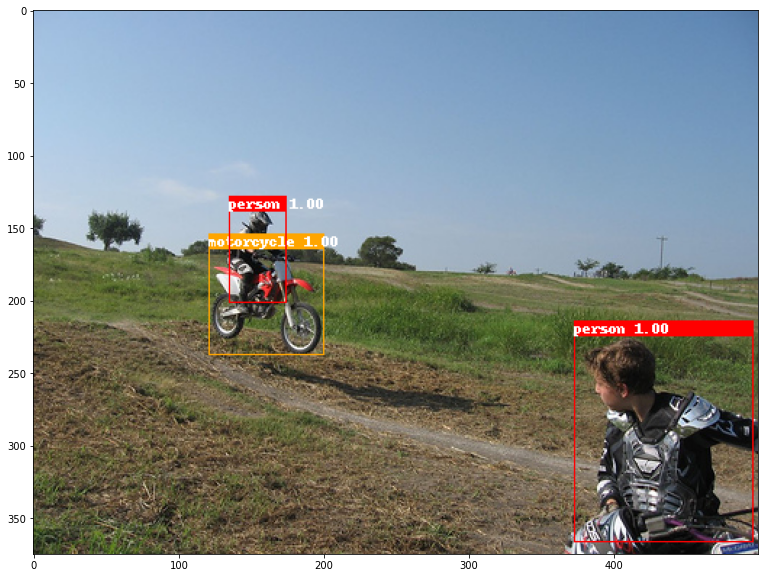

In [80]:
# рисуем результат

res = img.copy()
res_draw = ImageDraw.Draw(res)

for n in range(len(labels)): # для всех найденых объектов
    if scores[n]<0.7:continue # выкидываем объекты с низким скором
    print(text[n])
    fx0,fy0,fx1,fy1 = boxes[n,:].tolist() # координаты углов рамки объекта
    clr = colors[labels[n]] # цвет класса
    res_draw.rectangle( (fx0,fy0,fx1,fy1), outline=clr ) # рисуем рамку
    # подписываем
    tfp = fx0,fy0,fx1,fy0-10   # координаты рамки заголовка
    res_draw.rectangle(tfp,fill=clr)
    tx,ty = fx0,fy0-10 # координаты подписи
    res_draw.text((tx,ty),text[n],fill='white')
        

plt.figure(figsize=(15,10))
plt.imshow(res)

---

In [81]:
from matplotlib import colors as colors_convertor

# прообразуем имена цветов для классов в вектор RGB
colors_rgb = { 
    n: np.array(colors_convertor.to_rgba( colors[n] ))[:3] 
    for n in labels
}

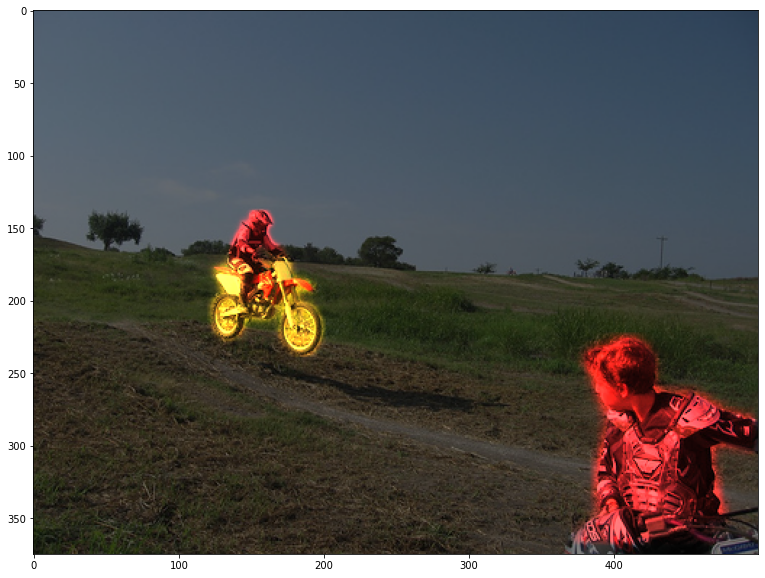

In [82]:
res = np.array(img.copy().convert('RGB'))*0.5 # конвертируем картинку в тензор

# формируем разноцветные маски объектов с достаточно большим скором
msk = sum([   
 np.transpose(masks[n],axes=(1,2,0)) * colors_rgb[labels[n]].reshape(1,1,3)
 for n in range(len(labels))
 if scores[n]>0.69
])

# накладываем маски объектов на картинку
res = Image.fromarray(np.uint8( np.clip((4.*res*msk)+res,a_min=0.,a_max=255.)))

plt.figure(figsize=(15,10))
plt.imshow(res)